# Chirp radio transmission simulation

To run this notebook you need numpy, scipy, matplotlib, cython, pandas and seaborn. 

In [28]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.figsize'] = (12, 9)

import pandas
import numpy
from scipy import stats

import pyximport
pyximport.install(reload_support=True)
from imp import reload
import chirptx

## Behaviours

The main simulation is defined in the file `chirptx.pyx`. It's written in Cython for speed. The following two functions are wrappers. There are two behaviours.

The `periodic` behaviour transmits with a fixed period each time. Periods are different for each device, 60 seconds on average, with a spread of 1 second, uniformly randomized at production time.

The `randomized_periodic` behaviour randomizes the period after each transmission, with the same spread. Every chirp has the same behaviour.

In [2]:
reload(chirptx)

def periodic(nchirps, period_mean, period_spread, duration):
    # delays ~ Exponential, with mean and var = 1
    delays = stats.expon.rvs(2, size=nchirps)
    
    # periods ~ Uniform(mean - spread/2, mean + spread/2)
    periods = stats.uniform.rvs(loc=period_mean - period_spread / 2,
                                scale=period_spread,
                                size=nchirps)
    
    return chirptx.simulate(
        numpy.array([chirptx.Periodic(p) for p in periods]),
        numpy.array(delays, dtype=float),
        duration)

def randomized_periodic(nchirps, period_mean, period_spread, duration):
    # delays ~ Exponential, with mean and var = 1
    delays = stats.expon.rvs(2, size=nchirps)
    
    return chirptx.simulate(
        numpy.array([chirptx.RandomizedPeriodic(period_mean, period_spread) for i in range(nchirps)]),
        numpy.array(delays, dtype=float),
        duration)

## Setup

Simulations are run for each behaviour and exponentially increasing numbers of chirps. The main result of each simulation is a probability that a single transmission will fail, independent of everything else.

24 hours are simulated, with a time step of 0.01 seconds. Each transmission takes 0.04 seconds.

In [3]:
nchirps = numpy.unique(numpy.ceil(numpy.power(2, numpy.arange(1, 6.01, step=0.2))).astype(numpy.int))
data = pandas.DataFrame(data=dict(
        nchirps=nchirps,
        failp_periodic = numpy.zeros(len(nchirps), dtype=numpy.float),
        failp_randomized_periodic = numpy.zeros(len(nchirps), dtype=numpy.float),
))
data.index = data.nchirps
nchirps

array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 14, 16, 19, 22, 25, 28, 32,
       37, 43, 49, 56, 64])

In [4]:
# Seed RNG for reproducibility
numpy.random.seed(1)

def run_sim(behaviour):
    for nchirps in data.nchirps:
        name = behaviour.__name__
        s = behaviour(nchirps=nchirps,
                      period_mean=60,
                      period_spread=1,
                      duration=24 * 60 * 60)
        p = s.failures / s.transmissions
        data['failp_{}'.format(name)].at[nchirps] = p
        print("P(transmission will fail|nchirps={nchirps}, {name}) = {p:.4f}".format(**locals()))

run_sim(periodic)
run_sim(randomized_periodic)

P(transmission will fail|nchirps=2, periodic) = 0.0021
P(transmission will fail|nchirps=3, periodic) = 0.0028
P(transmission will fail|nchirps=4, periodic) = 0.0042
P(transmission will fail|nchirps=5, periodic) = 0.0125
P(transmission will fail|nchirps=6, periodic) = 0.0201
P(transmission will fail|nchirps=7, periodic) = 0.0326
P(transmission will fail|nchirps=8, periodic) = 0.0331
P(transmission will fail|nchirps=10, periodic) = 0.0538
P(transmission will fail|nchirps=11, periodic) = 0.0682
P(transmission will fail|nchirps=13, periodic) = 0.0929
P(transmission will fail|nchirps=14, periodic) = 0.1125
P(transmission will fail|nchirps=16, periodic) = 0.1564
P(transmission will fail|nchirps=19, periodic) = 0.2013
P(transmission will fail|nchirps=22, periodic) = 0.2568
P(transmission will fail|nchirps=25, periodic) = 0.3004
P(transmission will fail|nchirps=28, periodic) = 0.3871
P(transmission will fail|nchirps=32, periodic) = 0.4692
P(transmission will fail|nchirps=37, periodic) = 0.5763

## Results

Note that the plot is log-log scale.

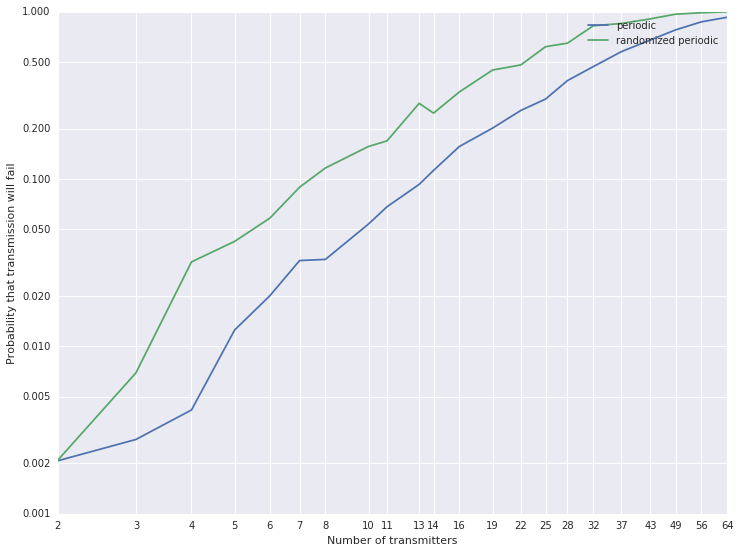

In [35]:
fig, ax = plt.subplots()
data.failp_periodic.plot(label="periodic", loglog=True)
data.failp_randomized_periodic.plot(label="randomized periodic", loglog=True)
plt.legend()
plt.xticks(data.nchirps)
plt.yticks([0.001, 0.002, 0.005, 0.010, 0.020, 0.050, 0.100, 0.200, 0.500, 1.000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel("Number of transmitters")
plt.ylabel("Probability that transmission will fail")